In [79]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import cv2 as cv

def generate_twiddle_factor_matrix(M, N):
    
    W_row = np.exp(1j * 2 * np.pi / M * np.outer(np.arange(M), np.arange(M)))
    
    W_col = np.exp(1j * 2 * np.pi / N * np.outer(np.arange(N), np.arange(N)))
    
    return W_row, W_col

def w2Current(w):
    
    hard_data=pd.read_excel('Paper_exp/DPE/GLSVLSI/Enc_Dec_v7/Mem_data/1T1R_SET_New_All.xlsx')

    r, i =hard_data["Read Res."].values, hard_data["Read Current "].values*1e-6

    G_H, G_L, mu, W_H =1/(np.min(r)*1e3), 1/(np.max(r)*1e3), np.min(w), np.max(w)

    alpha=(G_H-G_L)/(W_H+abs(mu))

    G=alpha*(w+abs(mu))+G_L

    R = ((1e-3/G).astype('int')).astype('str')

    dict_RI_map={}

    for (key,value) in zip(r,i):

        dict_RI_map[str(key)]=value

    R_df=pd.DataFrame(R)
    
    return R_df.replace(dict_RI_map)

def DFTMatrix2Current(W_row, W_col):
    
    wrow_real, wrow_imag = np.real(W_row), np.imag(W_row)
    
    Ir_real, Ir_img = w2Current(wrow_real), w2Current(wrow_imag)
    
    wcow_real, wcow_imag = np.real(W_col), np.imag(W_col)
    
    Ic_real, Ic_img = w2Current(wcow_real), w2Current(wcow_imag)
    
    return Ir_real, Ir_img, Ic_real, Ic_img


def ifft2d(fshift_):

    real_X, imag_X = np.real(fshift_), np.imag(fshift_)

    W_row, W_col = generate_twiddle_factor_matrix(fshift_.shape[0], fshift_.shape[1])
    
    Ir_real, Ir_img, Ic_real, Ic_img = DFTMatrix2Current(W_row, W_col)
    
    Real_K, Imag_K = np.dot(Ir_real, real_X) - np.dot(Ir_img, imag_X), np.dot(Ir_img, real_X) + np.dot(Ir_real,imag_X)
    
    complex_result = np.vectorize(complex)(Real_K, Imag_K)
    
    
    real_X, imag_X = np.real(complex_result), np.imag(complex_result)
    
    Real_K, Imag_K = np.dot(real_X,Ic_real) - np.dot(imag_X,Ic_img), np.dot(imag_X,Ic_real) + np.dot(real_X,Ic_img)
    
    complex_result = np.vectorize(complex)(Real_K, Imag_K)
    
    return Ir_real, Ir_img, Ic_real, Ic_img, complex_result

def reverse_fft_shift(fshift):
    
    rows, cols = fshift.shape
    
    center_row, center_col = rows // 2, cols // 2
    
    row_mask = np.hstack((np.arange(center_row, rows), np.arange(center_row)))
    
    col_mask = np.hstack((np.arange(center_col, cols), np.arange(center_col)))
    
    fshift_reverse = fshift[row_mask, :][:, col_mask]
    
    return fshift_reverse

(1335.0, 222.0)


<ipython-input-44-4d809361ea1f>:15: RuntimeWarning: divide by zero encountered in log
  magnitude_spectrum = 20*np.log(np.abs(fshift))


(Text(0.5, 1.0, 'MRI Kspace'), ([], []), ([], []))

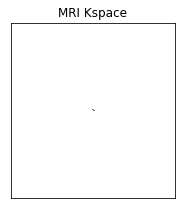

In [44]:
img = cv.imread('C:/Users/tusha/Downloads/MRI_of_Human_Brain.jpg', cv.IMREAD_GRAYSCALE)

fshift = np.fft.fftshift(np.fft.fft2(img))

fr,fi =100000, 100000

q_real, q_imag = ((np.real(fshift)/fr).astype('int')).astype(np.float32), ((np.imag(fshift)/fi).astype('int')).astype(np.float32)

real_level, imag_level = np.max(q_real) - np.min(q_real), np.max(q_imag) - np.min(q_imag)

print((real_level, imag_level))

fshift = np.vectorize(complex)(q_real, q_imag)

magnitude_spectrum = 20*np.log(np.abs(fshift))

plt.figure(figsize=(10,6))

plt.subplot(131),plt.imshow(magnitude_spectrum, cmap = 'gray')

plt.title('MRI Kspace'), plt.xticks([]), plt.yticks([])

(Text(0.5, 1.0, 'Reconstructed using Software'), ([], []), ([], []))

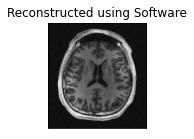

In [196]:
f_ishift = reverse_fft_shift(fshift)

img_back_soft = np.fft.ifft2(f_ishift)

plt.subplot(132),plt.imshow(np.real(img_back_soft), cmap = 'gray')

plt.title('Reconstructed using Software'), plt.xticks([]), plt.yticks([])

(Text(0.5, 1.0, 'Reconstructed using Memristor'), ([], []), ([], []))

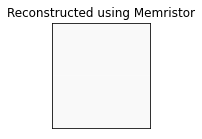

In [190]:
f_ishift = reverse_fft_shift(fshift)

img_back = ifft2d(f_ishift)

img_back = np.real(img_back)


plt.subplot(133),plt.imshow(img_back, cmap = 'gray')

plt.title('Reconstructed using Memristor'), plt.xticks([]), plt.yticks([])

In [188]:
def DFTMatrix2Current(W_row, num_bits):
    
    wrow_real, wrow_imag = np.real(W_row), np.imag(W_row)
    
    Ir_real, Ir_img = np.zeros((wrow_real.shape[0],wrow_real.shape[1],num_bits)), np.zeros((wrow_real.shape[0],wrow_real.shape[1],num_bits))
    
    Ir_real1, Ir_img1 = w2Current(wrow_real), w2Current(wrow_imag)
    
    for i in range(num_bits):
        
        Ir_real[:,:,i], Ir_img[:,:,i]= Ir_real1, Ir_img1
    
    return Ir_real, Ir_img

In [220]:
def dot_bit_slicing(rr_pos, Ir_real, num_bits, start, stop):

    ZZ = np.zeros((rr_pos.shape[0],rr_pos.shape[1],num_bits))

    for i in range(rr_pos.shape[0]):

        for j in range(rr_pos.shape[1]):

            bits = format(rr_pos[i,j], f'0{num_bits}b')

            for k in range(num_bits):

                ZZ[i,j,k]=bits[k]

    PP = np.zeros((rr_pos.shape[0],rr_pos.shape[1],num_bits))

    for i in range(num_bits):

        PP[:,:,i] = np.dot(ZZ[:,:,i],Ir_real[:,:,i]*2**(num_bits-1-i))

    return np.sum(PP,axis=-1)

In [221]:
fshift_ = f_ishift

"""
First Portion
"""

"Partition into real and imaginary"

real_X, imag_X = np.real(fshift_).T, np.imag(fshift_).T

"Generate the DFT matrix"

W_row, W_col = generate_twiddle_factor_matrix(fshift_.shape[0], fshift_.shape[1])

"Bits required for the real and imaginary part"

r_bit, i_bit = int(np.ceil(np.log2(np.max(real_X) - np.min(real_X)))), int(np.ceil(np.log2(np.max(imag_X) - np.min(imag_X))))

"Real Imagiray Current from weight"

Ir_real_r, Ir_img_r = DFTMatrix2Current(W_row, r_bit)

Ir_real_i, Ir_img_i = DFTMatrix2Current(W_row, i_bit)

Ic_real_i, Ic_img_i = DFTMatrix2Current(W_col, i_bit)

Ic_real_r, Ic_img_r = DFTMatrix2Current(W_col, r_bit)

"Real and Imaginary Part spread from 0 to Max with all the offsets"

rr_pos, rr_offset =  real_X - np.min(real_X), np.dot(np.zeros_like(real_X) + np.min(real_X), Ir_real_r[:,:,0])

im_pos, ii_offset = imag_X - np.min(imag_X), np.dot(np.zeros_like(imag_X) + np.min(imag_X), Ir_img_i[:,:,0])  

ri_offset, ir_offset = np.dot(np.zeros_like(real_X) + np.min(real_X), Ir_img_i[:,:,0]), np.dot(np.zeros_like(imag_X) + np.min(imag_X), Ir_real_i[:,:,0])

"Real K"

Real_K = dot_bit_slicing(rr_pos.astype('int'), Ir_real_r, r_bit) + rr_offset - (dot_bit_slicing(im_pos.astype('int'),Ir_img_i, i_bit) + ii_offset)

"Imag K"

Imag_K = dot_bit_slicing(rr_pos.astype('int'), Ir_img_r, r_bit) + dot_bit_slicing(im_pos.astype('int'), Ir_real_i, i_bit) + ri_offset + ir_offset
    
"Complex Result"

complex_result = np.vectorize(complex)(Real_K, Imag_K)



Ic_real, Ic_img = Ic_real_r[:,:,0], Ic_img_i[:,:,0]

real_X, imag_X = np.real(complex_result).T, np.imag(complex_result).T

rr_pos, rr_offset =  real_X - np.min(real_X), np.dot(np.zeros_like(real_X) + np.min(real_X), Ic_real)

im_pos, ii_offset = imag_X - np.min(imag_X), np.dot(np.zeros_like(imag_X) + np.min(imag_X), Ic_img)  

ri_offset, ir_offset = np.dot(np.zeros_like(real_X) + np.min(real_X), Ic_img), np.dot(np.zeros_like(imag_X) + np.min(imag_X), Ic_real)

Real_K = np.dot(rr_pos,Ic_real) + rr_offset - (np.dot(im_pos,Ic_img)+ii_offset)

Imag_K = np.dot(rr_pos, Ic_img) + np.dot(im_pos, Ic_real) + ri_offset + ir_offset

complex_result = np.vectorize(complex)(Real_K, Imag_K)

# """
# Second Portion
# """

# "Partition into real and imaginary"

# real_X, imag_X = np.real(complex_result).T, np.imag(complex_result).T

# "Bits required for the real and imaginary part"

# r_bit, i_bit = int(np.ceil(np.log2(np.max(real_X) - np.min(real_X)))), int(np.ceil(np.log2(np.max(imag_X) - np.min(imag_X))))

# "Real and Imaginary Part spread from 0 to Max with all the offsets"

# rr_pos, rr_offset =  real_X - np.min(real_X), np.dot(np.zeros_like(real_X) + np.min(real_X), Ic_real_r[:,:,0])

# im_pos, ii_offset = imag_X - np.min(imag_X), np.dot(np.zeros_like(imag_X) + np.min(imag_X), Ic_img_i[:,:,0])  

# ri_offset, ir_offset = np.dot(np.zeros_like(real_X) + np.min(real_X), Ic_img_i[:,:,0]), np.dot(np.zeros_like(imag_X) + np.min(imag_X), Ic_real_i[:,:,0])

# "Real K"

# Real_K = dot_bit_slicing(rr_pos.astype('int'), Ic_real_r, r_bit) + rr_offset - (dot_bit_slicing(im_pos.astype('int'),Ic_img_i, i_bit) + ii_offset)

# "Imag K"

# Imag_K = dot_bit_slicing(rr_pos.astype('int'), Ic_img_r, r_bit) + dot_bit_slicing(im_pos.astype('int'), Ic_real_i, i_bit) + ri_offset + ir_offset
    
# "Complex Result"

# complex_result = np.vectorize(complex)(Real_K, Imag_K)

In [117]:
Real_K = np.dot(rr_pos,Ir_real) + rr_offset - (np.dot(im_pos,Ir_img)+ii_offset)

In [170]:
PP_last = dot_bit_slicing(rr_pos, Ir_real, 11)

In [173]:
Real_K = np.dot(rr_pos,Ir_real[:,:,0])/(2**10)

In [ ]:
Imag_K = np.dot(rr_pos, Ir_img) + np.dot(im_pos, Ir_real) + ri_offset + ir_offset

complex_result = np.vectorize(complex)(Real_K, Imag_K)

In [ ]:
real_X, imag_X = np.real(complex_result).T, np.imag(complex_result).T

rr_pos, rr_offset =  real_X - np.min(real_X), np.dot(np.zeros_like(real_X) + np.min(real_X), Ic_real)

im_pos, ii_offset = imag_X - np.min(imag_X), np.dot(np.zeros_like(imag_X) + np.min(imag_X), Ic_img)  

ri_offset, ir_offset = np.dot(np.zeros_like(real_X) + np.min(real_X), Ic_img), np.dot(np.zeros_like(imag_X) + np.min(imag_X), Ic_real)

Real_K = np.dot(rr_pos,Ic_real) + rr_offset - (np.dot(im_pos,Ic_img)+ii_offset)

Imag_K = np.dot(rr_pos, Ic_img) + np.dot(im_pos, Ic_real) + ri_offset + ir_offset

complex_result = np.vectorize(complex)(Real_K, Imag_K)

In [84]:
def ifft2d(fshift_):

    real_X, imag_X = np.real(fshift_).T, np.imag(fshift_).T

    W_row, W_col = generate_twiddle_factor_matrix(fshift_.shape[0], fshift_.shape[1])
    
    Ir_real, Ir_img, Ic_real, Ic_img = DFTMatrix2Current(W_row, W_col)
    
    Real_K, Imag_K = np.dot(real_X, Ir_real) - np.dot(imag_X, Ir_img), np.dot(real_X,Ir_img) + np.dot(imag_X,Ir_real)
    
    complex_result = np.vectorize(complex)(Real_K, Imag_K)
    
    
    real_X, imag_X = np.real(complex_result).T, np.imag(complex_result).T
    
    Real_K, Imag_K = np.dot(real_X,Ic_real) - np.dot(imag_X,Ic_img), np.dot(imag_X,Ic_real) + np.dot(real_X,Ic_img)
    
    complex_result = np.vectorize(complex)(Real_K, Imag_K)
    
    return Ir_real, Ir_img, Ic_real, Ic_img, complex_result

In [114]:
def ifft2d(fshift_):
    
    fshift_ = f_ishift

    real_X, imag_X = np.real(fshift_).T, np.imag(fshift_).T

    W_row, W_col = generate_twiddle_factor_matrix(fshift_.shape[0], fshift_.shape[1])

    Ir_real, Ir_img, Ic_real, Ic_img = DFTMatrix2Current(W_row, W_col)

    rr_pos, rr_offset =  real_X - np.min(real_X), np.dot(np.zeros_like(real_X) + np.min(real_X), Ir_real)

    im_pos, ii_offset = imag_X - np.min(imag_X), np.dot(np.zeros_like(imag_X) + np.min(imag_X), Ir_img)  

    ri_offset, ir_offset = np.dot(np.zeros_like(real_X) + np.min(real_X), Ir_img), np.dot(np.zeros_like(imag_X) + np.min(imag_X), Ir_real)

    Real_K = np.dot(rr_pos,Ir_real) + rr_offset - (np.dot(im_pos,Ir_img)+ii_offset)

    Imag_K = np.dot(rr_pos, Ir_img) + np.dot(im_pos, Ir_real) + ri_offset + ir_offset
    
    complex_result = np.vectorize(complex)(Real_K, Imag_K)


    real_X, imag_X = np.real(complex_result).T, np.imag(complex_result).T

    rr_pos, rr_offset =  real_X - np.min(real_X), np.dot(np.zeros_like(real_X) + np.min(real_X), Ic_real)

    im_pos, ii_offset = imag_X - np.min(imag_X), np.dot(np.zeros_like(imag_X) + np.min(imag_X), Ic_img)  

    ri_offset, ir_offset = np.dot(np.zeros_like(real_X) + np.min(real_X), Ic_img), np.dot(np.zeros_like(imag_X) + np.min(imag_X), Ic_real)

    Real_K = np.dot(rr_pos,Ic_real) + rr_offset - (np.dot(im_pos,Ic_img)+ii_offset)

    Imag_K = np.dot(rr_pos, Ic_img) + np.dot(im_pos, Ic_real) + ri_offset + ir_offset

    complex_result = np.vectorize(complex)(Real_K, Imag_K)
    
    return Ir_real, Ir_img, Ic_real, Ic_img, complex_result

In [187]:
def ifft2d(fshift_):
    
    """
    First Portion
    """

    "Partition into real and imaginary"

    real_X, imag_X = np.real(fshift_).T, np.imag(fshift_).T

    "Generate the DFT matrix"

    W_row, W_col = generate_twiddle_factor_matrix(fshift_.shape[0], fshift_.shape[1])

    "Bits required for the real and imaginary part"

    r_bit, i_bit = int(np.ceil(np.log2(np.max(real_X) - np.min(real_X)))), int(np.ceil(np.log2(np.max(imag_X) - np.min(imag_X))))

    "Real Imagiray Current from weight"

    Ir_real_r, Ir_img_r = DFTMatrix2Current(W_row, r_bit)

    Ir_real_i, Ir_img_i = DFTMatrix2Current(W_row, i_bit)

    Ic_real_i, Ic_img_i = DFTMatrix2Current(W_col, i_bit)

    Ic_real_r, Ic_img_r = DFTMatrix2Current(W_col, r_bit)

    "Real and Imaginary Part spread from 0 to Max with all the offsets"

    rr_pos, rr_offset =  real_X - np.min(real_X), np.dot(np.zeros_like(real_X) + np.min(real_X), Ir_real_r[:,:,0])

    im_pos, ii_offset = imag_X - np.min(imag_X), np.dot(np.zeros_like(imag_X) + np.min(imag_X), Ir_img_i[:,:,0])  

    ri_offset, ir_offset = np.dot(np.zeros_like(real_X) + np.min(real_X), Ir_img_i[:,:,0]), np.dot(np.zeros_like(imag_X) + np.min(imag_X), Ir_real_i[:,:,0])

    "Real K"

    Real_K = dot_bit_slicing(rr_pos.astype('int'), Ir_real_r, r_bit) + rr_offset - (dot_bit_slicing(im_pos.astype('int'),Ir_img_i, i_bit) + ii_offset)

    "Imag K"

    Imag_K = dot_bit_slicing(rr_pos.astype('int'), Ir_img_r, r_bit) + dot_bit_slicing(im_pos.astype('int'), Ir_real_i, i_bit) + ri_offset + ir_offset

    "Complex Result"

    complex_result = np.vectorize(complex)(Real_K, Imag_K)

    """
    Second Portion
    """

    "Partition into real and imaginary"

    real_X, imag_X = np.real(complex_result).T, np.imag(complex_result).T

    "Bits required for the real and imaginary part"

    r_bit, i_bit = int(np.ceil(np.log2(np.max(real_X) - np.min(real_X)))), int(np.ceil(np.log2(np.max(imag_X) - np.min(imag_X))))

    "Real and Imaginary Part spread from 0 to Max with all the offsets"

    rr_pos, rr_offset =  real_X - np.min(real_X), np.dot(np.zeros_like(real_X) + np.min(real_X), Ic_real_r[:,:,0])

    im_pos, ii_offset = imag_X - np.min(imag_X), np.dot(np.zeros_like(imag_X) + np.min(imag_X), Ic_img_i[:,:,0])  

    ri_offset, ir_offset = np.dot(np.zeros_like(real_X) + np.min(real_X), Ic_img_i[:,:,0]), np.dot(np.zeros_like(imag_X) + np.min(imag_X), Ic_real_i[:,:,0])


    "Real K"

    Real_K = dot_bit_slicing(rr_pos.astype('int'), Ic_real_r, r_bit) + rr_offset - (dot_bit_slicing(im_pos.astype('int'),Ic_img_i, i_bit) + ii_offset)

    "Imag K"

    Imag_K = dot_bit_slicing(rr_pos.astype('int'), Ic_img_r, r_bit) + dot_bit_slicing(im_pos.astype('int'), Ic_real_i, i_bit) + ri_offset + ir_offset

    "Complex Result"

    complex_result = np.vectorize(complex)(Real_K, Imag_K)
    
    return complex_result

In [114]:
# Example usage:

def linear_quantization(fshift, levels=256):

    original_array = np.real(fshift)

    min_org = abs(np.min(original_array))

    TF = original_array + min_org

    Std_int = (((TF/np.max(TF))*levels).astype('int')).astype(np.float32)

    q_real = (Std_int/levels)*np.max(TF) - abs(np.min(original_array))

    original_array = np.imag(fshift)

    min_org = abs(np.min(original_array))

    TF = original_array + min_org

    Std_int = ((TF/np.max(TF))*levels).astype('int')

    q_imag = (Std_int/levels)*np.max(TF) - abs(np.min(original_array))

    complex_result = np.vectorize(complex)(q_real, q_imag)

    return complex_result

In [115]:
# def linear_quantization(array, num_levels=256):
#     # Ensure the array is numpy array
#     array = np.array(array)

#     # Get the minimum and maximum values of the original array
#     min_value = array.min()
#     max_value = array.max()

#     # Compute the scaling factor and offset for linear quantization
#     scale_factor = (num_levels - 1) / (max_value - min_value)
#     offset = -min_value * scale_factor

#     # Apply linear quantization
#     quantized_array = np.round(array * scale_factor + offset)

#     # Clip values to ensure they are within the specified range
#     quantized_array = np.clip(quantized_array, 0, num_levels - 1)

#     return quantized_array.astype(int)


# q_real = linear_quantization(np.real(fshift))

# q_imag = linear_quantization(np.imag(fshift))

# complex_result = np.vectorize(complex)(q_real, q_imag)

In [116]:
CA= linear_quantization(fshift, levels=65536)

(Text(0.5, 1.0, 'Reconstructed using Memristor'), ([], []), ([], []))

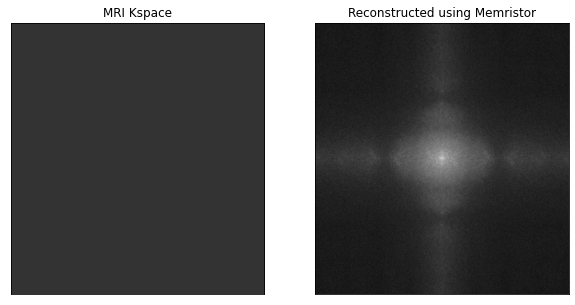

In [117]:
plt.figure(figsize=(10,6))

plt.subplot(121),plt.imshow(original_array, cmap = 'gray')

plt.title('MRI Kspace'), plt.xticks([]), plt.yticks([])

plt.subplot(122),plt.imshow(20*np.log(np.abs(CA)), cmap = 'gray')

plt.title('Reconstructed using Memristor'), plt.xticks([]), plt.yticks([])

In [173]:
import tkinter as tk
from tkinter import ttk

def create_tab(tab_name):
    tab = ttk.Frame(notebook)
    notebook.add(tab, text=tab_name)
    label = tk.Label(tab, text=f"This is the {tab_name} tab")
    label.pack(padx=10, pady=10)

# Create the main window
root = tk.Tk()
root.title("Tab Example")

# Create a Notebook widget
notebook = ttk.Notebook(root)

# Create tabs
create_tab("Tab 1")
create_tab("Tab 2")
create_tab("Tab 3")

# Pack the Notebook widget to make it visible
notebook.pack(expand=1, fill="both")

# Run the Tkinter event loop
root.mainloop()